**Outline**
1. Preparation
    
2. Analysis
    * Review and analysis of full dataset
        * Trends and seasonality
    * Closer analysis of trends and seasonality
        * Month
        * Week
        * Day
3. Training
    * Prepare data
        * Differencing to remove trends
        * Create features 
        * Split into training and test sets 
    * Train models
        * Linear Regression
        * Random Forest Regressor
        * CatBoost Regressor
4. Testing
    * Evaluate model using RMSE metric
    * Conclusion

**Objective**

Build a model to predict taxi orders in one hour.

# 1. Preparation

In [1]:
import calendar
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df = df.resample('1H').sum()

In [5]:
df = df.sort_index()

In [6]:
df.index.is_monotonic

True

In [7]:
df['rolling_mean'] = df.rolling(20).mean()

In [8]:
df['rolling_std'] = df['num_orders'].rolling(20).std()

In [9]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.dayofweek
df['hour'] = df.index.hour

To start, I used `read_csv` to open the file, turn the date column into the index, and convert it contents from `object` to `datetime64` datatypes. I also resampled by the hour, and made sure the data was in chronological order. Finally, I added a number of features that would be used in later analysis - numerical representations of the year, month, day, weekday, and hour.

# 2. Analysis

**Review and analysis of full dataset** 

In [10]:
df['num_orders'].describe()

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64

I first looked over the numerical distribution of the `num_orders` column, for a general idea of what the least, most, and average number of taxi orders were.  

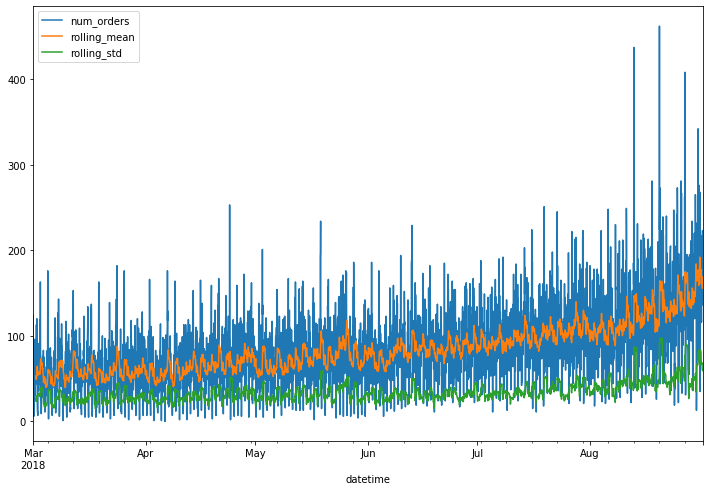

In [11]:
df.loc[:,['num_orders','rolling_mean','rolling_std']].plot(figsize=(12,8))

I also did an initial plot of the the dataset. The graph is very noisy, but the trend shows an increase of orders over time, and increasing dispersion somewhere around August.

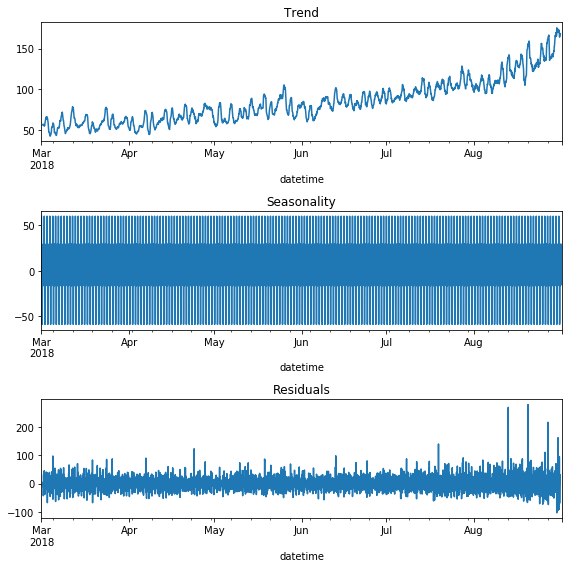

In [12]:
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

The general trend is slightly more evident at this timescale, but seasonality is extremely hard to decipher. In order to better understand what kind of patterns might be in the data, I decided to analyse by month, week, and day as well. 

**Analysis by month, week**

In [13]:
df['trend_data'] = decomposed.trend
df['seasonal_data'] = decomposed.seasonal
df['residuals_data'] = decomposed.resid

In [14]:
months = df['month'].unique()

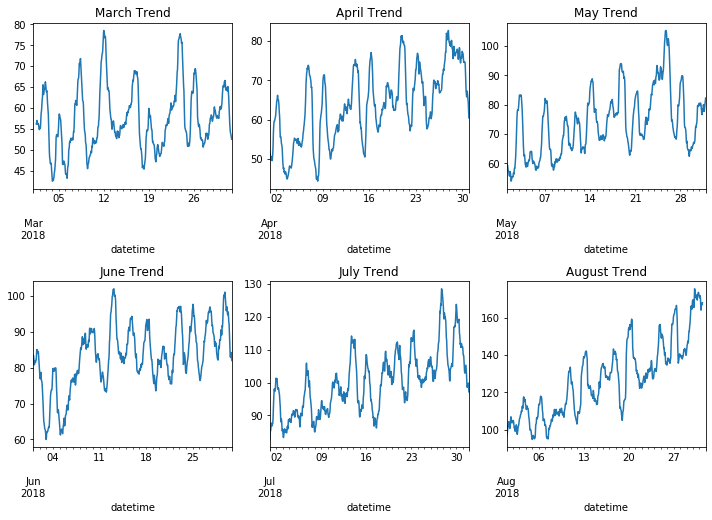

In [15]:
plt.figure(figsize=(10,10))
idx = 330

for month in months:
    month_decomposed = df[df['month'] == month]['trend_data']
    idx += 1
    
    plt.subplot(idx)
    month_decomposed.plot(ax=plt.gca())
    plt.title('{} Trend'.format(calendar.month_name[month]))

plt.tight_layout()

Generally, ride orders increase at the end of the month, and fluctuate quite a bit day to day.

In [16]:
print(df['num_orders'].mean())

print(df.groupby(pd.Grouper(freq='M'))['num_orders'].agg('mean'))

84.42278079710145
datetime
2018-03-31     57.483871
2018-04-30     63.804167
2018-05-31     73.682796
2018-06-30     83.202778
2018-07-31    100.006720
2018-08-31    127.651882
Freq: M, Name: num_orders, dtype: float64


Next, I looked at the mean number of orders for each month, and compared them to the overall mean of the entire dataset. The closest was June, so I felt it would be the best one to analyse individually and look for potential patterns.

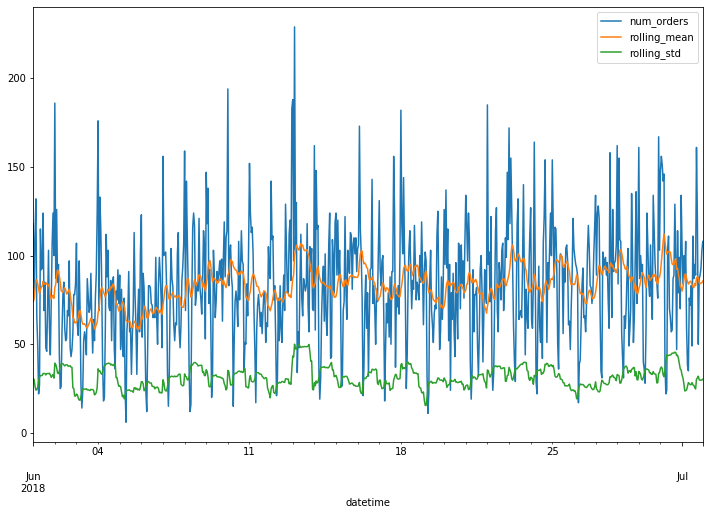

In [17]:
df_month = df['2018-06-01':'2018-07-01']

df_month.loc[:,['num_orders','rolling_mean','rolling_std']].plot(figsize=(12,8))

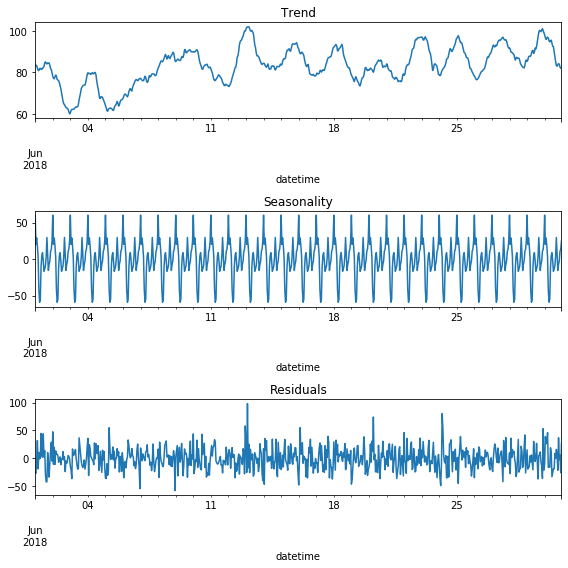

In [18]:
june = df[df['month'] == 6]

plt.figure(figsize=(8, 8))

plt.subplot(311)
june['trend_data'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
june['seasonal_data'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
june['residuals_data'].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

The seasonality in June appears to be daily, with an amplitude of about 100 orders.  

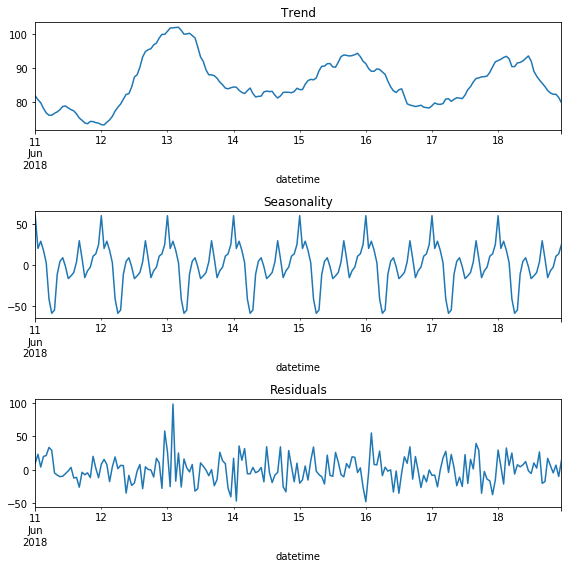

In [19]:
june_week = df['2018-06-11':'2018-06-18']

plt.figure(figsize=(8, 8))

plt.subplot(311)
june_week['trend_data'].plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
june_week['seasonal_data'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
june_week['residuals_data'].plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

In [20]:
idx = pd.date_range(start='2018-06-11', freq='D', periods=8)
idx.day_name()

Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday', 'Monday'],
      dtype='object')

For this week in June, orders jumped on Tuesdays, Wednesdays, and Fridays. These are popular days to travel, so this seems reasonable. It also appears that the daily trends change depending on the day of the week - the number of taxis ordered increases steadily from morning until late evening for popular days, and decreases steadily for unpopular days. 

# 3. Training

**Prepare data for model training**

In [25]:
df_model = pd.DataFrame(df['num_orders'])

for lag in range(1,4):
    df_model['lag_{}'.format(lag)] = df_model['num_orders'].shift(lag)
    
for rolling in range(5,30,5):
    df_model['rolling_mean_shifted_{}'.format(rolling)] = df_model['num_orders'].shift().rolling(rolling).mean()
    
df_model = df_model.join(df[['year', 'month','hour', 'day', 'weekday']])

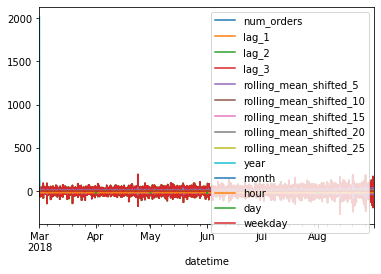

In [26]:
df_model = df_model - df_model.shift(fill_value=0)

df_model.plot()

In [27]:
train, test = train_test_split(df_model, shuffle=False, test_size=.1)

In [28]:
train = train.dropna()
test = test.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

To prepare my data for model training, I made it stationary by differencing, added more features that the model could use, split it into training and test sets, and eliminated rows with NaN values. I also designated features and targets.

In [29]:
def rmse(t, p):
    return mean_squared_error(t, p) ** .5

**Train Linear Regression model**

In [30]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print("RMSE for Linear Regression model:", rmse(target_test, predictions))

RMSE for Linear Regression model: 49.22870405658006


**Train Random Forest model**

In [31]:
for params in itertools.product([20, 50, 100], [2, 4, 6], ['auto']):
    estim = params[0]
    depth = params[1]
    feat = params[2]
    
    model = RandomForestRegressor(n_estimators=estim, max_depth=depth, max_features=feat, random_state=12345)
    model.fit(features_train, target_train)
    predictions = model.predict(features_train)
    
    print("Rmse for {} estimators {} max depth {} features: {}".format(estim, depth, feat, 
                                                                       rmse(target_train, predictions)))

Rmse for 20 estimators 2 max depth auto features: 31.436000988311378
Rmse for 20 estimators 4 max depth auto features: 28.47578819560069
Rmse for 20 estimators 6 max depth auto features: 26.111020931536288
Rmse for 50 estimators 2 max depth auto features: 31.327541630809154
Rmse for 50 estimators 4 max depth auto features: 28.37643896923096
Rmse for 50 estimators 6 max depth auto features: 26.061010636817617
Rmse for 100 estimators 2 max depth auto features: 31.32256099546223
Rmse for 100 estimators 4 max depth auto features: 28.378765979072703
Rmse for 100 estimators 6 max depth auto features: 26.028947108446282


**Train CatBoost model**

In [32]:
for params in itertools.product([300, 500], [4, 6, 10]):
    iters = params[0]
    depth = params[1]
    
    model = CatBoostRegressor(iterations=iters, depth=depth, boosting_type='Plain', 
                              verbose=False, leaf_estimation_iterations=1)
    model.fit(features_train, target_train)
    predictions = model.predict(features_train)
    
    print("Rmse for {} iterations {} depth: {}".format(iters, depth, rmse(target_train, predictions)))

Rmse for 300 iterations 4 depth: 26.486062213517776
Rmse for 300 iterations 6 depth: 25.292405756167064
Rmse for 300 iterations 10 depth: 22.314928939046048
Rmse for 500 iterations 4 depth: 25.284254364339063
Rmse for 500 iterations 6 depth: 23.598303675235726
Rmse for 500 iterations 10 depth: 19.28261066193678


# 4. Testing

**Test Random Forest model**

In [34]:
model_rf = RandomForestRegressor(n_estimators=100, max_depth=6, max_features='auto', random_state=12345)
model_rf.fit(features_train, target_train) 
predictions_test_rf = model_rf.predict(features_test)
print("RMSE for test predictions: ", rmse(target_test, predictions_test_rf))

RMSE for test predictions:  50.678015502270505


**Test CatBoost model**

In [35]:
model_cv = CatBoostRegressor(iterations=500, depth=10, boosting_type='Plain', 
                             verbose=False, leaf_estimation_iterations=1)
model_cv.fit(features_train, target_train)
predictions_test_cv = model_cv.predict(features_test)
print("RMSE for test predictions: ", rmse(target_test, predictions_test_cv))

RMSE for test predictions:  46.43742471484326


In [36]:
target_test_median = np.ones(target_test.shape) * test['num_orders'].median()


print("Baseline RMSE using median orders for predictions: ", mean_squared_error(target_test,
                                                            target_test_median) ** .5)

Baseline RMSE using median orders for predictions:  58.87064007163026


To see which model performed best with a test set, I tried both and calculated the RMSE for each of their predictions. To better understand the quality of my models, I also calculated the RMSE for predictions that were simply the median value of the targets. In comparison, the CatBoost model does quite a bit better, and is under the target RMSE. It does seem to be overfitted, however. 

# Conclusions

Trends to consider when forecasting airport taxi orders are that high traffic days are Wednesday and Friday evening, orders increase at the end of the month, and pickups drop significantly between 3 and 6 AM while remaining more steady after 12 PM. Demand also seems to fluctuate by about 100 orders in a day and 40 orders in 6 hours. 

The CatBoostRegressor model that I trained has an RMSE of ~46. The RMSE for the median number of orders shows what not accounting for fluctuations at all looks like - an average error of 60 orders. The trained model brings this error down by about a quarter. 

Using the trained model in conjuction with the observations enumerated above, predicting and planning for changes in demand would be an improvement over using an average constant demand. 